In [12]:
import cvxpy as cp
from scipy.optimize import nnls

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore") 

In [13]:
factor = 1
population = pd.read_csv("data/bfs_population_age.csv")

for year in [2010, 2015, 2021]: 
    hh = pd.read_csv(f"data/mz_original/households_{year}.csv")
    indiv = pd.read_csv(f"data/mz_original/individuals_{year}.csv")
    hh['hid_role'] = hh[['hid', 'role']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    indiv['hid_role'] = indiv[['hid', 'role']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

    hh_w_ms = hh.copy()
    ms_role_dict = indiv[['hid_role', 'marital_status']].set_index('hid_role').to_dict()['marital_status']
    ms_dict = indiv[['hid', 'marital_status']].set_index('hid').to_dict()['marital_status']

    hh_w_ms.loc[(hh_w_ms.htype.isin([210, 220])) & (hh_w_ms.role < 3), 'marital_status'] = hh_w_ms['hid'].map(ms_dict)
    hh_w_ms.loc[(hh_w_ms.htype.isin([10, 30, 230])), 'marital_status'] = hh_w_ms['hid_role'].map(ms_role_dict)
    hh_w_ms.loc[hh_w_ms.marital_status.isna(), 'marital_status'] = 1

    hh_w_ms.drop(columns=['hid_role'], inplace=True)

    globals()[f'hh_w_ms_{year}'] = hh_w_ms.copy()



In [ ]:
# GENERATE NEW WEIGHTS 

for year in [2010, 2015, 2021]:
    ######## GENERATE NEW WEIGHTS ########
    hh_w_ms = globals()[f'hh_w_ms_{year}'].copy()

    # reweight census age 1-99 (drop 0 and 100)
    pop_rw = population[(population.Year==year)][['Age','Population']].groupby('Age').sum().reset_index().sort_values(by='Age')
    t_vec = pop_rw['Population'].to_numpy()

    hh_w_ms.loc[hh_w_ms.age > 99, "age"] = 99
    h_matrix = hh_w_ms.pivot_table(index='hid', columns='age', values='role', aggfunc='count').fillna(0).astype(int).to_numpy()

    ####### SECOND REWEIGHT ALG ######
    num_households = len(h_matrix)

    # ── (3) Set up and solve the QP in cvxpy:
    w = cp.Variable(shape=(num_households,), nonneg=True)

    # Objective:  minimize sum_i (w_i - 1)^2
    objective = cp.Minimize(cp.sum_squares(w - 1.0))

    # Constraint:  Hmat^T @ w == T
    constraints = [ h_matrix.T @ w == t_vec ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP)  # OSQP or any QP‐capable solver

    reprojection_error = np.linalg.norm(h_matrix.T @ w.value - t_vec)

    ############### ATTACH WEIGHTS TO hh_2010_new_weights ###############
    hh_new_weights = globals()[f'hh_w_ms_{year}'].copy()

    # Attach the new weights from the variable w (solution from the QP) to hh_2010_new_weights
    # First, create a DataFrame with 'hid' and the corresponding weight
    weights_df = pd.DataFrame({'hid': hh_new_weights.hid.unique(), 'new_weight': w.value})

    # Merge the weights into hh_new_weights
    hh_new_weights = hh_new_weights.merge(weights_df, on='hid', how='left')
    globals()[f'hh_new_weights_{year}'] = hh_new_weights.copy()

In [15]:
######## REWEIGHT - WITH NEW WEIGHTS ########

for year in [2010, 2015, 2021]:
    hh_new_weights = globals()[f'hh_new_weights_{year}'].copy()

    to_replicate = hh_new_weights[['hid','new_weight']].drop_duplicates()
    replicated_hid = to_replicate.sample(int(len(to_replicate)*factor*0.9), weights=to_replicate['new_weight'], replace=True)

    replica_count = replicated_hid.hid.value_counts().to_dict()

    hh_new_weights['replicate_n'] = hh_new_weights['hid'].map(replica_count).fillna(0).astype(int)
    hh_new_weights = hh_new_weights.loc[hh_new_weights['replicate_n'] > 0]
    hh_new_weights['temp_id'] = hh_new_weights['hid'].astype(str) + '_' + hh_new_weights['role'].astype(str)

    # Step 1: Repeat rows according to 'replicate_n'
    hh_new_rw = hh_new_weights.loc[hh_new_weights.index.repeat(hh_new_weights['replicate_n'])].copy()
    
    # Step 2: Create the 'n_rep' column
    hh_new_rw['n_rep'] = hh_new_rw.groupby('temp_id').cumcount()
    max_hid = hh_new_rw['hid'].max()
    hh_new_rw['hid'] = hh_new_rw['hid'] + max_hid*hh_new_rw['n_rep']

    globals()[f'hh_new_rw_{year}'] = hh_new_rw.copy()

In [16]:
######## REWEIGHT - WITH ORIGINAL WEIGHTS ########
for year in [2010, 2015, 2021]:
    hh_old_weights = globals()[f'hh_w_ms_{year}'].copy()

    to_replicate = hh_old_weights[['hid','hhweight']].drop_duplicates()
    replicated_hid = to_replicate.sample(len(to_replicate)*factor, weights=to_replicate['hhweight'], replace=True)

    replica_count = replicated_hid.hid.value_counts().to_dict()

    hh_old_weights['replicate_n'] = hh_old_weights['hid'].map(replica_count).fillna(0).astype(int)
    hh_old_weights = hh_old_weights.loc[hh_old_weights['replicate_n'] > 0]
    hh_old_weights['temp_id'] = hh_old_weights['hid'].astype(str) + '_' + hh_old_weights['role'].astype(str)

    # Step 1: Repeat rows according to 'replicate_n'
    hh_old_rw = hh_old_weights.loc[hh_old_weights.index.repeat(hh_old_weights['replicate_n'])].copy()

    # Step 2: Create the 'n_rep' column
    hh_old_rw['n_rep'] = hh_old_rw.groupby('temp_id').cumcount()
    max_hid = hh_old_rw['hid'].max()
    hh_old_rw['hid'] = hh_old_rw['hid'] + max_hid*hh_old_rw['n_rep']

    globals()[f'hh_old_rw_{year}'] = hh_old_rw.copy()



In [17]:
# NORMALIZE HTYPE 
for year in [2010, 2015, 2021]:
    
    # 1. Original microcensus data (NOT reweighted)
    hh_w_ms = globals()[f'hh_w_ms_{year}'].copy()


    # 2. Microcensus with OLD weights
    hh_old_rw = globals()[f'hh_old_rw_{plot_year}'].copy()
    old_rw = hh_old_rw[hh_old_rw.age < 100]
    old_rw['Sex'] = old_rw['gender'].map({1: 'M', 2: 'F'})
    old_rw_grouped = old_rw.groupby(['age', 'Sex']).size().unstack(fill_value=0)

    # 3. Microcensus with NEW weights
    hh_new_rw = globals()[f'hh_new_rw_{plot_year}'].copy()
    new_rw = hh_new_rw[hh_new_rw.age < 100]
    new_rw['Sex'] = new_rw['gender'].map({1: 'M', 2: 'F'})
    new_rw_grouped = new_rw.groupby(['age', 'Sex']).size().unstack(fill_value=0)

    total_ms = hh_w_ms.htype.value_counts(normalize=True) * 100
    total_old_rw = hh_old_rw.htype.value_counts(normalize=True) * 100
    total_new_rw = hh_new_rw.htype.value_counts(normalize=True) * 100

    print(f"YEAR: {year}")
    print(f"hh_w_ms_{year} (original weights):\n", total_ms)
    print(f"\nhh_old_rw_{year} (replicated, original weights):\n", total_old_rw)
    print(f"\nhh_new_rw_{year} (replicated, new weights):\n", total_new_rw, "\n\n\n")

IndentationError: unexpected indent (398124984.py, line 22)

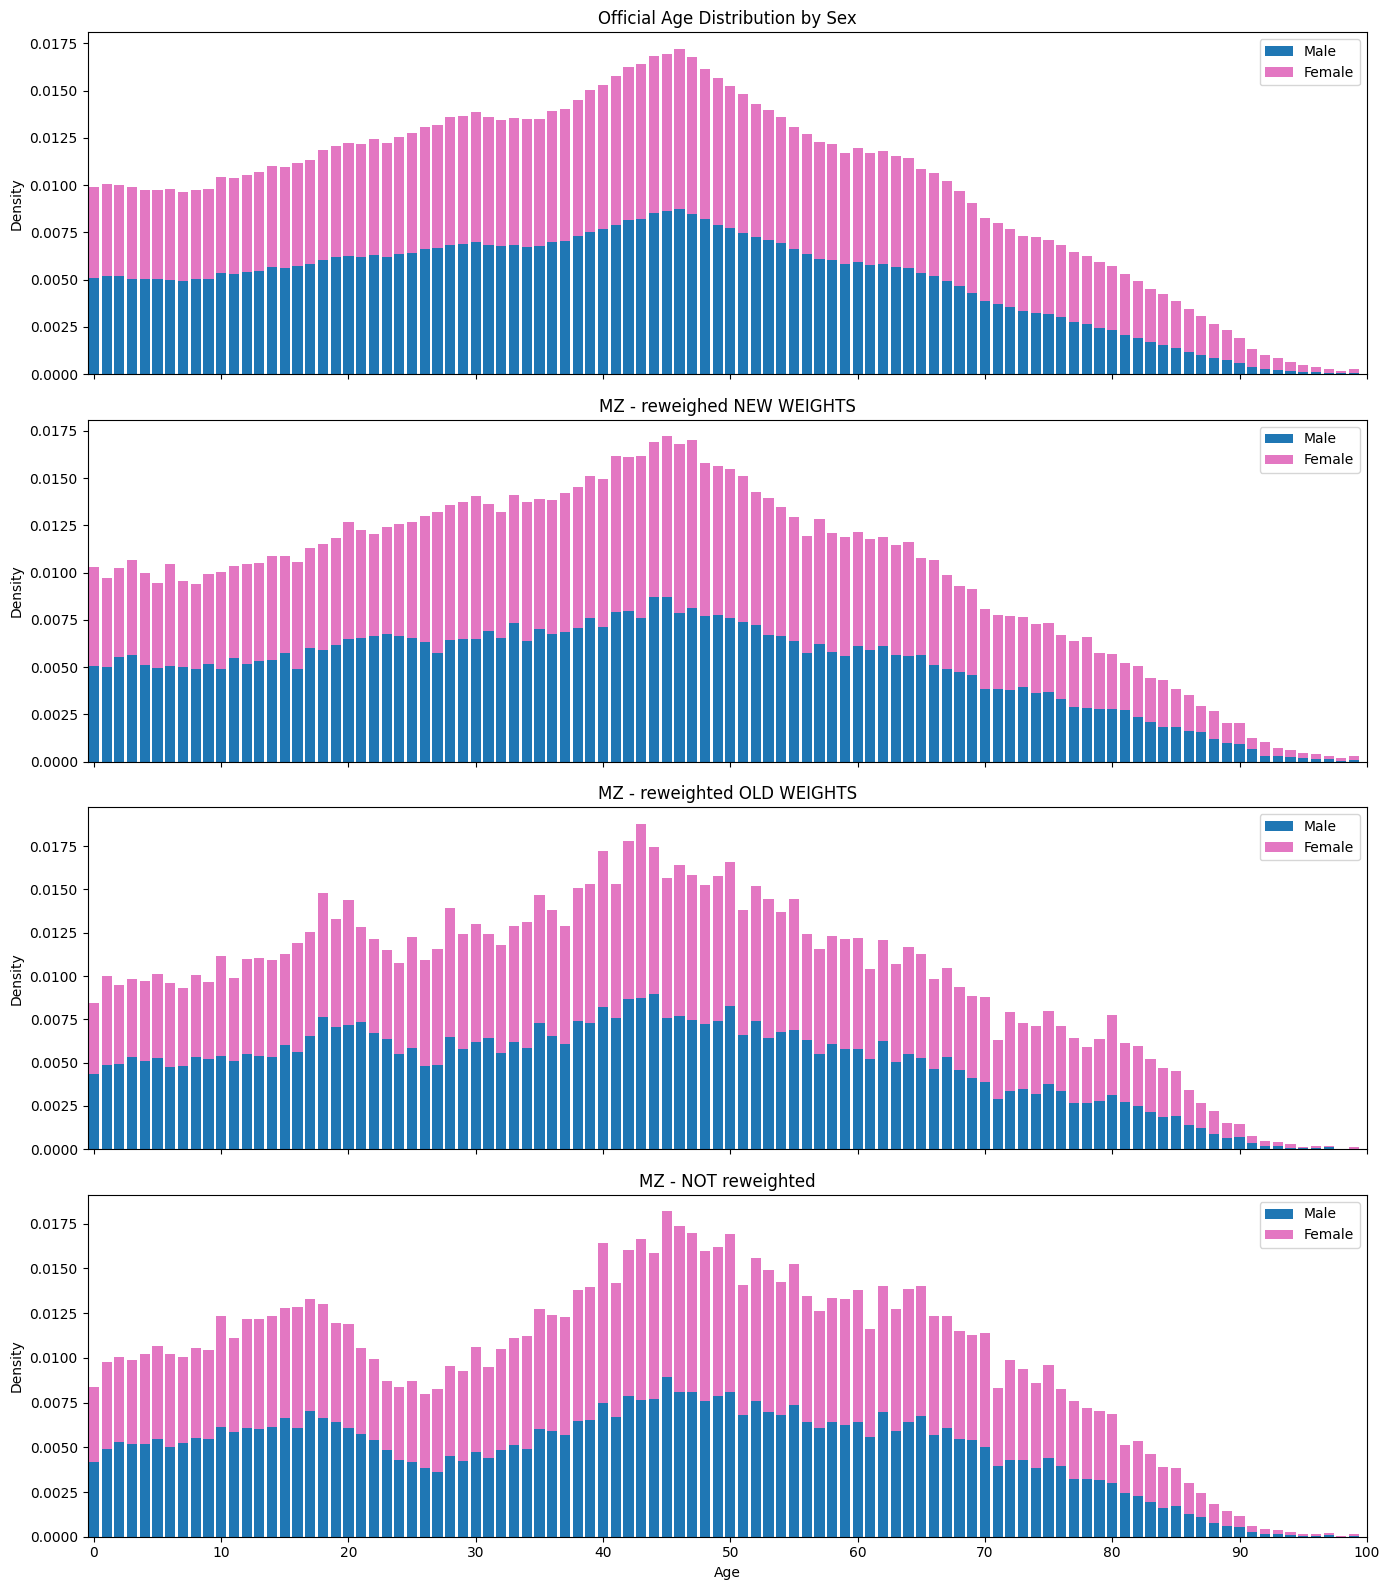

In [11]:
######## PLOT AGE DISTRIBUTIONS 2010 ########

plot_year = 2010

# Prepare data for plotting
# 1. Official population (plot_year), grouped by age and sex
official_pop = population[(population.Year == plot_year) & (population.Age < 100)]
official_grouped = official_pop.groupby(['Age', 'Sex'])['Population'].sum().unstack(fill_value=0)

# 2. Microcensus with NEW weights
hh_new_rw = globals()[f'hh_new_rw_{plot_year}'].copy()
new_rw = hh_new_rw[hh_new_rw.age < 100]
new_rw['Sex'] = new_rw['gender'].map({1: 'M', 2: 'F'})
new_rw_grouped = new_rw.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# 3. Microcensus with OLD weights
hh_old_rw = globals()[f'hh_old_rw_{plot_year}'].copy()
old_rw = hh_old_rw[hh_old_rw.age < 100]
old_rw['Sex'] = old_rw['gender'].map({1: 'M', 2: 'F'})
old_rw_grouped = old_rw.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# 4. Original microcensus data (NOT reweighted)
hh = globals()[f'hh_w_ms_{plot_year}'].copy()
orig = hh[hh.age < 100]
orig['Sex'] = orig['gender'].map({1: 'M', 2: 'F'})
orig_grouped = orig.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# Normalize to density for comparison
official_density = official_grouped.div(official_grouped.sum().sum())
new_rw_density = new_rw_grouped.div(new_rw_grouped.sum().sum())
old_rw_density = old_rw_grouped.div(old_rw_grouped.sum().sum())
orig_density = orig_grouped.div(orig_grouped.sum().sum())



# Plotting the age distributions
ages = np.arange(0, 100)

fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# 1. Official
axes[0].bar(ages, official_density['M'], color='tab:blue', alpha=1, label='Male')
axes[0].bar(ages, official_density['F'], color='tab:pink', alpha=1, bottom=official_density['M'], label='Female')
axes[0].set_ylabel("Density")
axes[0].set_title("Official Age Distribution by Sex")
axes[0].set_xlim(0, 100)
axes[0].legend()

# 2. Microcensus with new weights
axes[1].bar(ages, new_rw_density['M'], color='tab:blue', alpha=1, label='Male')
axes[1].bar(ages, new_rw_density['F'], color='tab:pink', alpha=1, bottom=new_rw_density['M'], label='Female')
axes[1].set_ylabel("Density")
axes[1].set_title("MZ - reweighed NEW WEIGHTS")
axes[1].set_xlim(0, 100)
axes[1].legend()

# 3. Microcensus with old WEIGHTS
# Note: old_rw_density may not have age=0, so align with ages present
old_ages = old_rw_density.index.values
axes[2].bar(old_ages, old_rw_density['M'], color='tab:blue', alpha=1, label='Male')
axes[2].bar(old_ages, old_rw_density['F'], color='tab:pink', alpha=1, bottom=old_rw_density['M'], label='Female')
axes[2].set_ylabel("Density")
axes[2].set_title("MZ - reweighted OLD WEIGHTS")
axes[2].set_xlim(0, 100)
axes[2].legend()


# 24. Microcensus original (not replicated)
axes[3].bar(ages, orig_density['M'], color='tab:blue', alpha=1, label='Male')
axes[3].bar(ages, orig_density['F'], color='tab:pink', alpha=1, bottom=orig_density['M'], label='Female')
axes[3].set_xlabel("Age")
axes[3].set_ylabel("Density")
axes[3].set_title("MZ - NOT reweighted")
axes[3].set_xlim(-0.5, 100)
axes[3].set_xticks(np.arange(0, 101, 10))
axes[3].legend()


plt.tight_layout()
plt.show()


C:\Users\artur\AppData\Local\Temp\ipykernel_22636\2309083104.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rw['Sex'] = new_rw['gender'].map({1: 'M', 2: 'F'})
C:\Users\artur\AppData\Local\Temp\ipykernel_22636\2309083104.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_rw['Sex'] = old_rw['gender'].map({1: 'M', 2: 'F'})
C:\Users\artur\AppData\Local\Temp\ipykernel_22636\2309083104.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

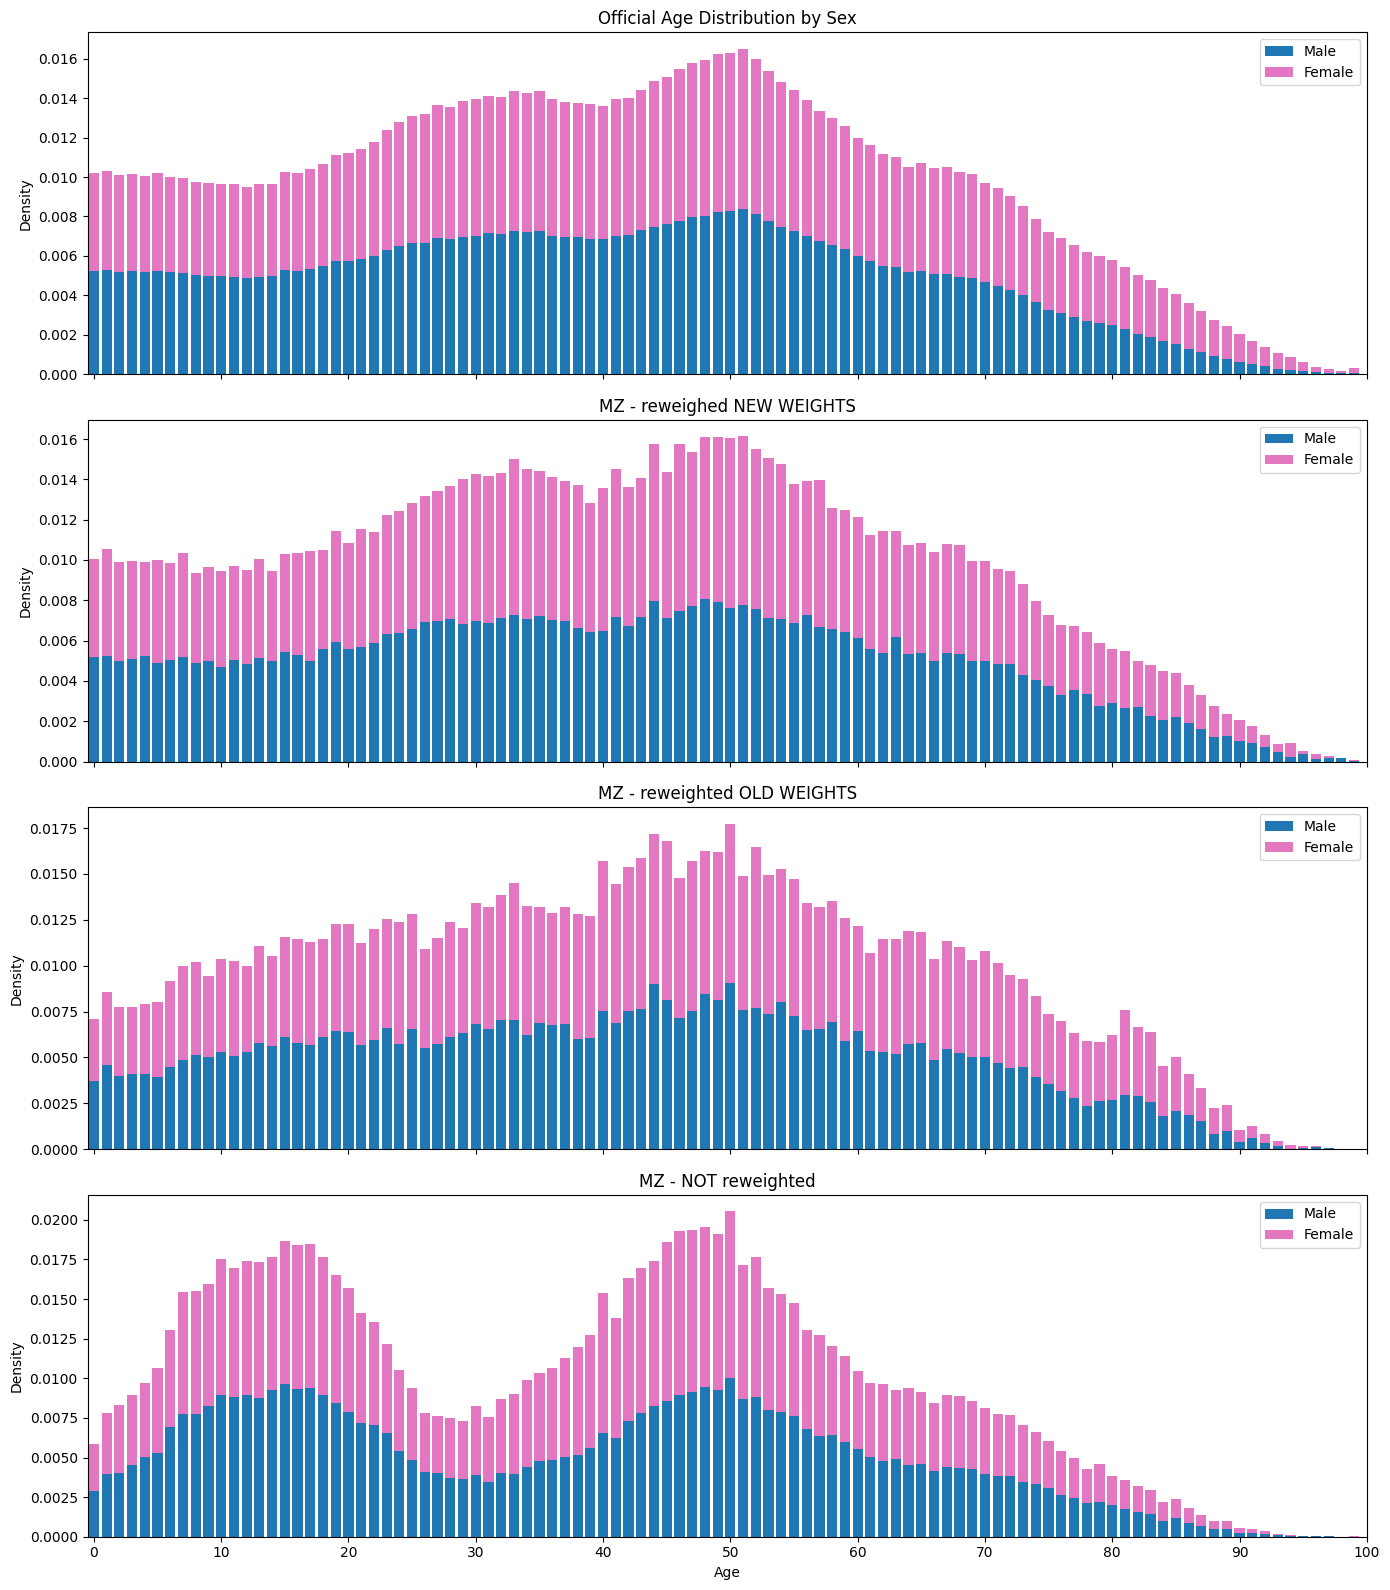

In [7]:
######## PLOT AGE DISTRIBUTIONS 2015 ########

plot_year = 2015

# Prepare data for plotting
# 1. Official population (plot_year), grouped by age and sex
official_pop = population[(population.Year == plot_year) & (population.Age < 100)]
official_grouped = official_pop.groupby(['Age', 'Sex'])['Population'].sum().unstack(fill_value=0)

# 2. Microcensus with NEW weights
hh_new_rw = globals()[f'hh_new_rw_{plot_year}'].copy()
new_rw = hh_new_rw[hh_new_rw.age < 100]
new_rw['Sex'] = new_rw['gender'].map({1: 'M', 2: 'F'})
new_rw_grouped = new_rw.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# 3. Microcensus with OLD weights
hh_old_rw = globals()[f'hh_old_rw_{plot_year}'].copy()
old_rw = hh_old_rw[hh_old_rw.age < 100]
old_rw['Sex'] = old_rw['gender'].map({1: 'M', 2: 'F'})
old_rw_grouped = old_rw.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# 4. Original microcensus data (NOT reweighted)
hh = globals()[f'hh_w_ms_{plot_year}'].copy()
orig = hh[hh.age < 100]
orig['Sex'] = orig['gender'].map({1: 'M', 2: 'F'})
orig_grouped = orig.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# Normalize to density for comparison
official_density = official_grouped.div(official_grouped.sum().sum())
new_rw_density = new_rw_grouped.div(new_rw_grouped.sum().sum())
old_rw_density = old_rw_grouped.div(old_rw_grouped.sum().sum())
orig_density = orig_grouped.div(orig_grouped.sum().sum())



# Plotting the age distributions
ages = np.arange(0, 100)

fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# 1. Official
axes[0].bar(ages, official_density['M'], color='tab:blue', alpha=1, label='Male')
axes[0].bar(ages, official_density['F'], color='tab:pink', alpha=1, bottom=official_density['M'], label='Female')
axes[0].set_ylabel("Density")
axes[0].set_title("Official Age Distribution by Sex")
axes[0].set_xlim(0, 100)
axes[0].legend()

# 2. Microcensus with new weights
axes[1].bar(ages, new_rw_density['M'], color='tab:blue', alpha=1, label='Male')
axes[1].bar(ages, new_rw_density['F'], color='tab:pink', alpha=1, bottom=new_rw_density['M'], label='Female')
axes[1].set_ylabel("Density")
axes[1].set_title("MZ - reweighed NEW WEIGHTS")
axes[1].set_xlim(0, 100)
axes[1].legend()

# 3. Microcensus with old WEIGHTS
# Note: old_rw_density may not have age=0, so align with ages present
old_ages = old_rw_density.index.values
axes[2].bar(old_ages, old_rw_density['M'], color='tab:blue', alpha=1, label='Male')
axes[2].bar(old_ages, old_rw_density['F'], color='tab:pink', alpha=1, bottom=old_rw_density['M'], label='Female')
axes[2].set_ylabel("Density")
axes[2].set_title("MZ - reweighted OLD WEIGHTS")
axes[2].set_xlim(0, 100)
axes[2].legend()


# 24. Microcensus original (not replicated)
axes[3].bar(ages, orig_density['M'], color='tab:blue', alpha=1, label='Male')
axes[3].bar(ages, orig_density['F'], color='tab:pink', alpha=1, bottom=orig_density['M'], label='Female')
axes[3].set_xlabel("Age")
axes[3].set_ylabel("Density")
axes[3].set_title("MZ - NOT reweighted")
axes[3].set_xlim(-0.5, 100)
axes[3].set_xticks(np.arange(0, 101, 10))
axes[3].legend()


plt.tight_layout()
plt.show()


C:\Users\artur\AppData\Local\Temp\ipykernel_22636\679240340.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rw['Sex'] = new_rw['gender'].map({1: 'M', 2: 'F'})
C:\Users\artur\AppData\Local\Temp\ipykernel_22636\679240340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_rw['Sex'] = old_rw['gender'].map({1: 'M', 2: 'F'})
C:\Users\artur\AppData\Local\Temp\ipykernel_22636\679240340.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

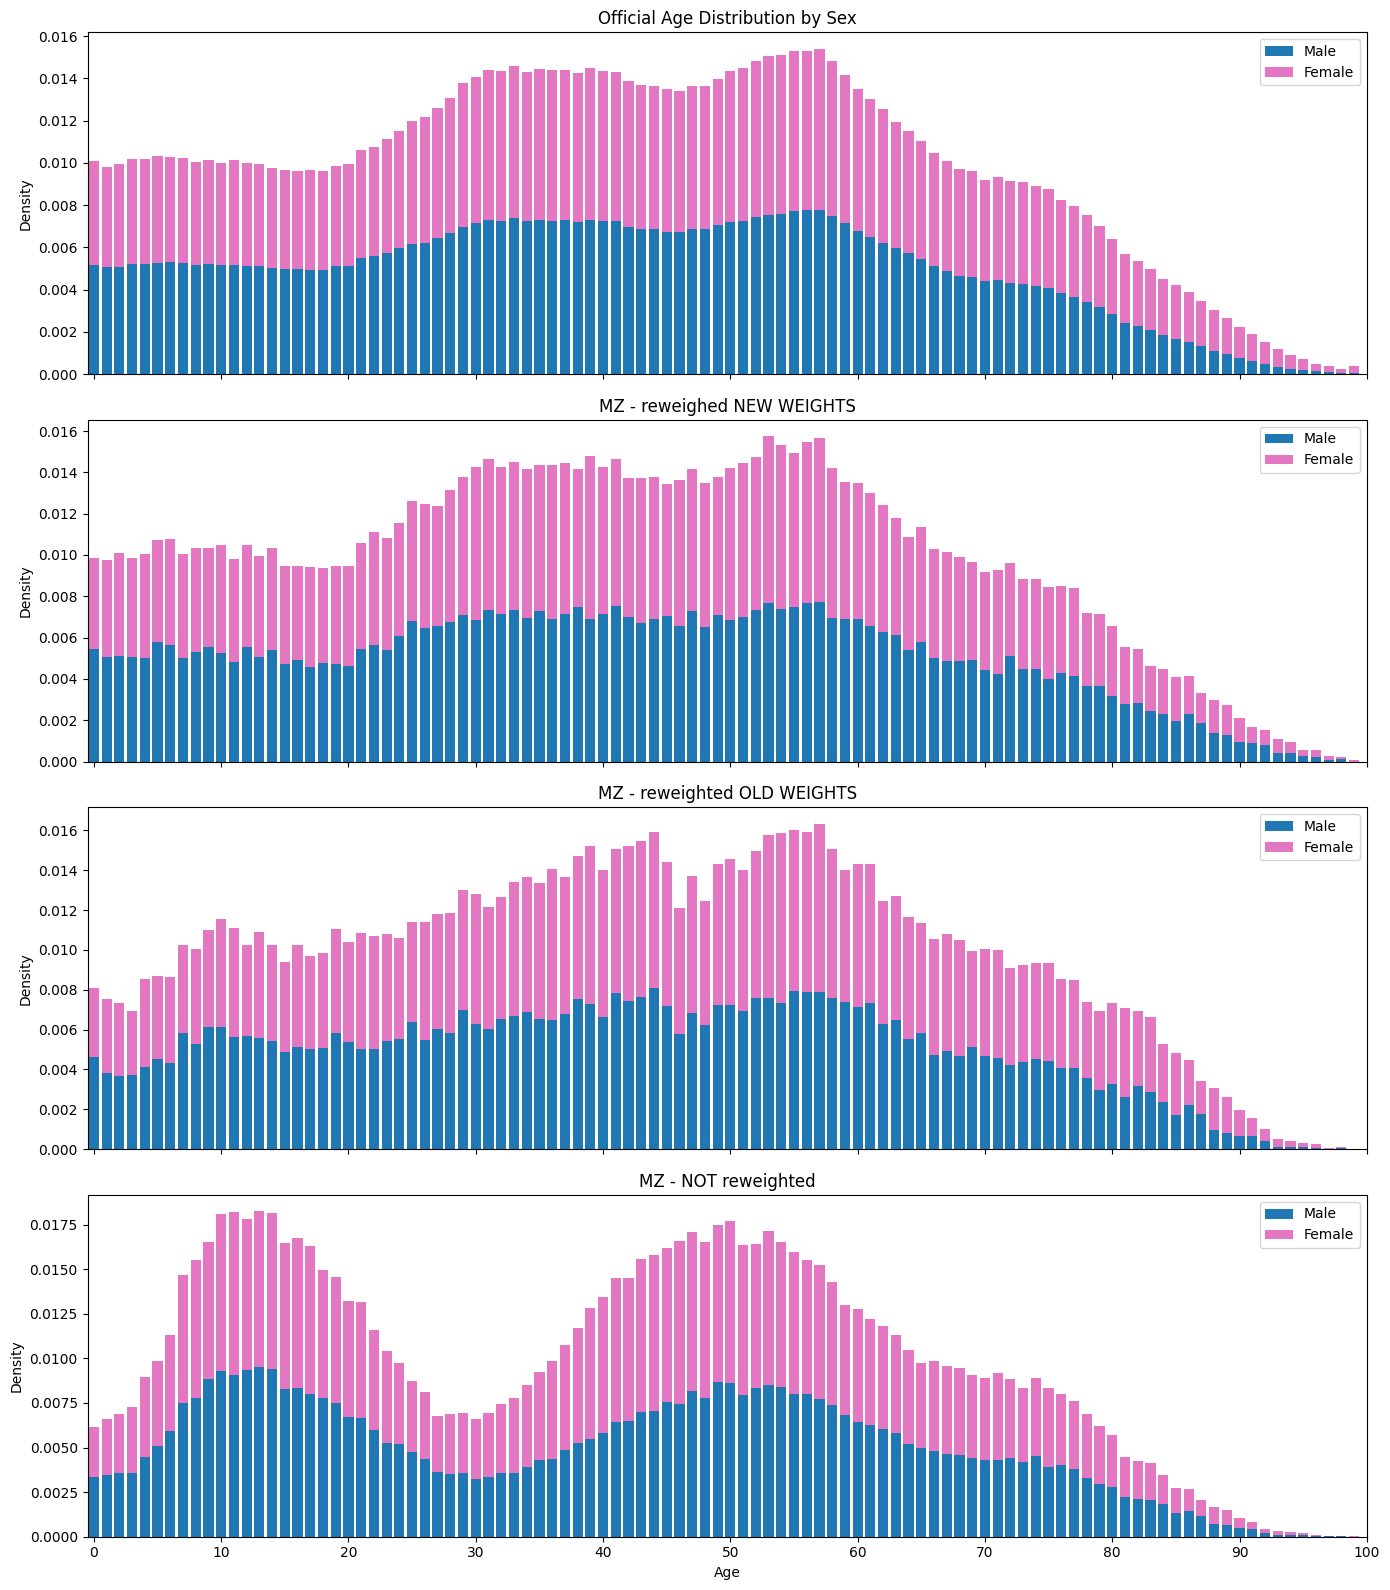

In [8]:
######## PLOT AGE DISTRIBUTIONS 2021 ########

plot_year = 2021

# Prepare data for plotting
# 1. Official population (plot_year), grouped by age and sex
official_pop = population[(population.Year == plot_year) & (population.Age < 100)]
official_grouped = official_pop.groupby(['Age', 'Sex'])['Population'].sum().unstack(fill_value=0)

# 2. Microcensus with NEW weights
hh_new_rw = globals()[f'hh_new_rw_{plot_year}'].copy()
new_rw = hh_new_rw[hh_new_rw.age < 100]
new_rw['Sex'] = new_rw['gender'].map({1: 'M', 2: 'F'})
new_rw_grouped = new_rw.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# 3. Microcensus with OLD weights
hh_old_rw = globals()[f'hh_old_rw_{plot_year}'].copy()
old_rw = hh_old_rw[hh_old_rw.age < 100]
old_rw['Sex'] = old_rw['gender'].map({1: 'M', 2: 'F'})
old_rw_grouped = old_rw.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# 4. Original microcensus data (NOT reweighted)
hh = globals()[f'hh_w_ms_{plot_year}'].copy()
orig = hh[hh.age < 100]
orig['Sex'] = orig['gender'].map({1: 'M', 2: 'F'})
orig_grouped = orig.groupby(['age', 'Sex']).size().unstack(fill_value=0)

# Normalize to density for comparison
official_density = official_grouped.div(official_grouped.sum().sum())
new_rw_density = new_rw_grouped.div(new_rw_grouped.sum().sum())
old_rw_density = old_rw_grouped.div(old_rw_grouped.sum().sum())
orig_density = orig_grouped.div(orig_grouped.sum().sum())



# Plotting the age distributions
ages = np.arange(0, 100)

fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# 1. Official
axes[0].bar(ages, official_density['M'], color='tab:blue', alpha=1, label='Male')
axes[0].bar(ages, official_density['F'], color='tab:pink', alpha=1, bottom=official_density['M'], label='Female')
axes[0].set_ylabel("Density")
axes[0].set_title("Official Age Distribution by Sex")
axes[0].set_xlim(0, 100)
axes[0].legend()

# 2. Microcensus with new weights
axes[1].bar(ages, new_rw_density['M'], color='tab:blue', alpha=1, label='Male')
axes[1].bar(ages, new_rw_density['F'], color='tab:pink', alpha=1, bottom=new_rw_density['M'], label='Female')
axes[1].set_ylabel("Density")
axes[1].set_title("MZ - reweighed NEW WEIGHTS")
axes[1].set_xlim(0, 100)
axes[1].legend()

# 3. Microcensus with old WEIGHTS
# Note: old_rw_density may not have age=0, so align with ages present
old_ages = old_rw_density.index.values
axes[2].bar(old_ages, old_rw_density['M'], color='tab:blue', alpha=1, label='Male')
axes[2].bar(old_ages, old_rw_density['F'], color='tab:pink', alpha=1, bottom=old_rw_density['M'], label='Female')
axes[2].set_ylabel("Density")
axes[2].set_title("MZ - reweighted OLD WEIGHTS")
axes[2].set_xlim(0, 100)
axes[2].legend()


# 24. Microcensus original (not replicated)
axes[3].bar(ages, orig_density['M'], color='tab:blue', alpha=1, label='Male')
axes[3].bar(ages, orig_density['F'], color='tab:pink', alpha=1, bottom=orig_density['M'], label='Female')
axes[3].set_xlabel("Age")
axes[3].set_ylabel("Density")
axes[3].set_title("MZ - NOT reweighted")
axes[3].set_xlim(-0.5, 100)
axes[3].set_xticks(np.arange(0, 101, 10))
axes[3].legend()


plt.tight_layout()
plt.show()


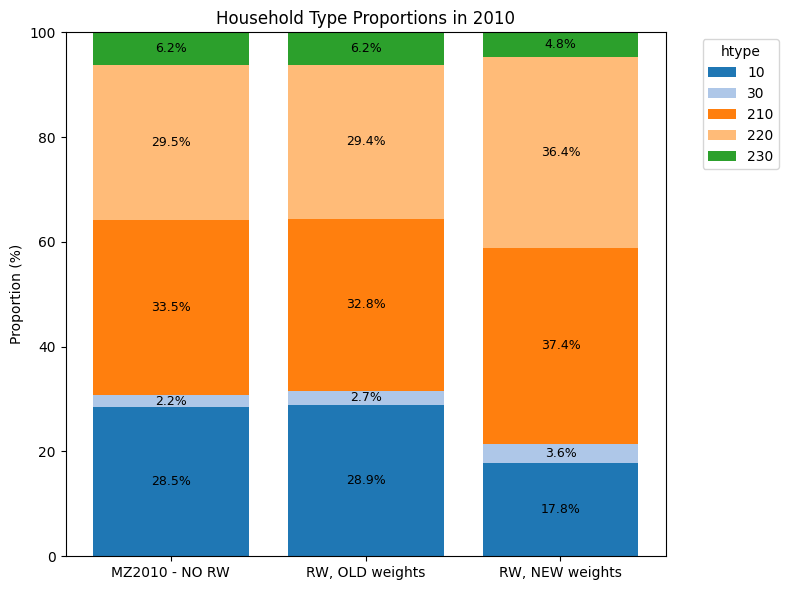

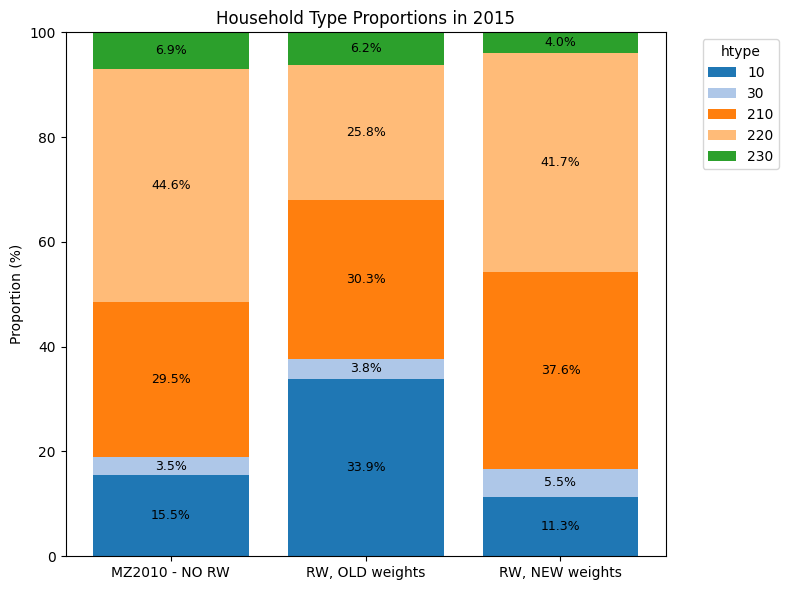

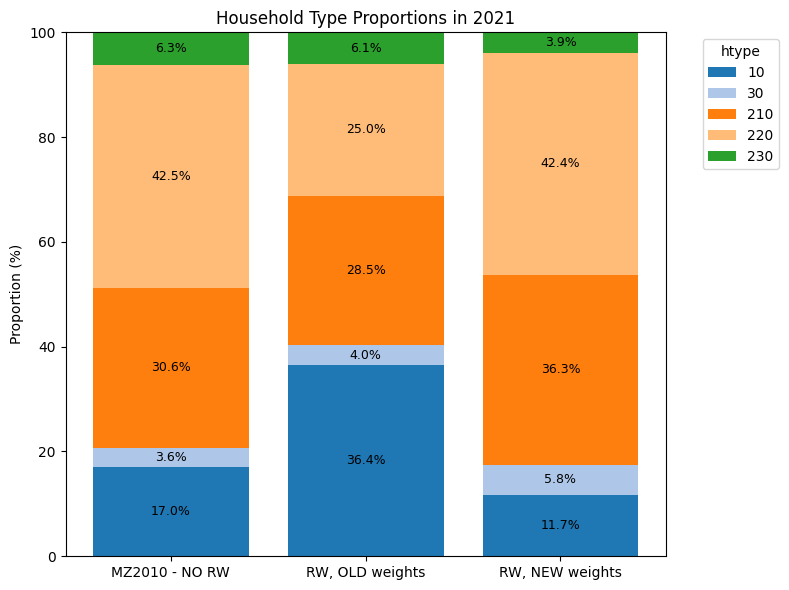

In [19]:
# Prepare htype proportions for each dataset

for year in [2010, 2015, 2021]:
    hh_w_ms = globals()[f'hh_w_ms_{year}'].copy()
    hh_old_rw = globals()[f'hh_old_rw_{year}'].copy()
    hh_new_rw = globals()[f'hh_new_rw_{year}'].copy()

    datasets = [
        ("MZ2010 - NO RW", hh_w_ms),
        ("RW, OLD weights", hh_old_rw),
        ("RW, NEW weights", hh_new_rw)
    ]

    # Get all unique htype values across datasets for consistent stacking order
    all_htypes = sorted(
        set().union(*[df.groupby('hid')['htype'].first().unique() for _, df in datasets])
    )

    # Build a DataFrame with htype proportions for each dataset
    proportion_data = []
    for name, df in datasets:
        htype_counts = df.groupby('hid')['htype'].first().value_counts(normalize=True)
        row = [htype_counts.get(htype, 0) * 100 for htype in all_htypes]
        proportion_data.append(row)

    proportion_df = pd.DataFrame(proportion_data, columns=all_htypes, index=[name for name, _ in datasets])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    bottom = np.zeros(len(proportion_df))
    colors = sns.color_palette("tab20", n_colors=len(all_htypes))

    for idx, htype in enumerate(all_htypes):
        values = proportion_df[htype].values
        bars = ax.bar(proportion_df.index, values, bottom=bottom, color=colors[idx], label=str(htype))
        # Add percentage labels
        for bar, value in zip(bars, values):
            if value > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{value:.1f}%",
                    ha='center', va='center', fontsize=9, color='black'
                )
        bottom += values

    ax.set_ylabel("Proportion (%)")
    ax.set_ylim(0, 100)
    ax.set_title(f"Household Type Proportions in {year}")
    ax.legend(title="htype", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()